## A Denoising autoencoder.  
see details in the blog "Another look at Autoencoders in Science Applications." in www.cloud4scieng.org  

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# to select the noise model to use, set the following variable.
#it is either uniform, cosine or original
NOISE = 'uniform'
  
# defining the Dataset class
class data_set(Dataset):
    def __init__(self, nums):
        numbers = nums
        self.data = numbers
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        return self.data[index]

In [3]:
def replace_data1(x):
    z = np.zeros(x.shape)
    d = -0.5
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            q = 0.3*(np.random.random()-0.5)+x[i,j]
            if q > 0.65+d:
                q  =  0.65+d
            if q < 0.35+d:
                q = 0.35+d
            z[i,j]= q
    return z

In [4]:
def replace_data2(x):    
    z = np.zeros(x.shape)
    d = -0.5
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            q = 0.25*(np.cos(j*np.pi/10)-0.5)+x[i,j]
            if q > 0.62+d:
                q  =  0.62+d
            if q < 0.2+d:
                q = 0.2+d
            z[i,j]= q+.1
    return z


In [5]:
import os
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1R-qfxO1jVh88TC9Gnm9JGMomSRg0Zpkx"
output = 'radio_data.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=True)

f = np.load(output)
n_train = 40000

x_train0 = f["traces"]  # measured traces (signal + colored noise)
signals0 = f["signals"]  # signal part (only available for cosmic-ray events)

if NOISE == 'uniform':
    x_train0 = replace_data1(signals0)
elif NOISE == 'cosine':
    x_train0 = replace_data2(signals0)

labels0 = (signals0.std(axis=-1) != 0).astype(float)  # define training label (1=cosmic event, 0=noise)
x_train = x_train0[:n_train]
x_test = x_train0[n_train:]


In [6]:
signals0.shape

(50000, 500)

In [7]:
sigs_train  = signals0[:n_train]
sigs_test = signals0[n_train:]
#we do not use labels for this example
#labels_train =labels0[:n_train]
#labels_test = labels0[n_train:]
#sigs_train = signals[:n_train]
#sigs_test = signals[n_train:]


In [8]:
x_train.std()

0.08710300365028235

In [9]:
sigma = x_train.std()
sigma = 1
x_train = x_train/sigma+0.5
x_test = x_test/sigma+0.5
sigs_train= sigs_train/sigma+0.5
sigs_test  = sigs_test/sigma+0.5


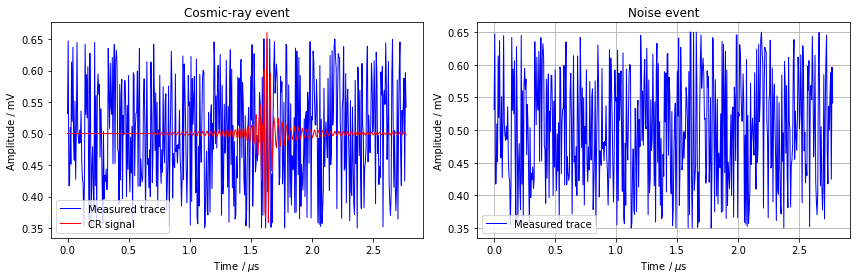

In [10]:
idx =10
fs = 180e6  # Sampling frequency of antenna setup 180 MHz
t = np.arange(500) / fs * 1e6

plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
#plt.plot(t, np.real(f["traces"][labels.astype(bool)][idx]), linewidth = 1, color="b", label="Measured trace")
plt.plot(t, np.real(x_train[idx]), linewidth = 1, color="b", label="Measured trace")
plt.plot(t, np.real(0.8*(sigs_train[idx]-0.5)+0.5), linewidth = 1, color="r", label="CR signal")
plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')
plt.legend()
plt.title("Cosmic-ray event")
plt.subplot(1, 2, 2)

plt.plot(t, np.real(x_train[idx]), linewidth = 1, color="b", label="Measured trace")
#plt.plot(t, np.real(x_train[~y_train.astype(bool)][idx2]), linewidth = 1, color="b", label="Measured trace")
plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')
plt.legend()
plt.title("Noise event")

plt.grid(True)
plt.tight_layout()

In [11]:
biglist = []
for i in range(n_train):
    item = [torch.tensor(x_train[i]).unsqueeze(0).float()]
    item.append(torch.tensor(sigs_train[i]).unsqueeze(0).float())
    biglist.append(item)

In [12]:
dataset = data_set(biglist)

In [13]:
batch_size = 20

  
biglist1 = []
for i in range(len(x_test)):
    item = [torch.tensor(x_test[i]).unsqueeze(0).float()]
    item.append(torch.tensor(sigs_test[i]).unsqueeze(0).float())
    biglist1.append(item)
    
testset = data_set(biglist1)
traindat = data_set(biglist)


In [14]:
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv1d(1,32,3,padding=1) 
        self.conv2 = nn.Conv1d(32,64,3,padding=1) 
        self.conv3 = nn.Conv1d(64,32,3,padding=1) 
        self.conv4 = nn.Conv1d(32,16,3, padding = 1)
        self.pool = nn.MaxPool1d(2,stride=2) # 4*4*32
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv0 = nn.ConvTranspose1d(16, 32, 2,stride=2)
        self.t_conv1 = nn.ConvTranspose1d(32, 32, 3, stride=2) # Output: 7*7*32
        self.t_conv2 = nn.ConvTranspose1d(32,64,2,stride=2) # Output: 14*14*64 
        self.t_conv3 = nn.ConvTranspose1d(64, 32 ,2,stride=2) # Output: 28*28*32
        self.conv_out = nn.Conv1d(32, 1, 3, padding=1) # Output: 28*28*1

    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))#1->32,500
        x = self.pool(x)#32->32,250
        c1 = F.relu(self.conv2(x)) # 32->64, 250
        x = self.pool(c1)# 64->64, 125
        c2 = F.relu(self.conv3(x)) # 64->32, 125
        x = self.pool(c2) #32->32, 62
        x = F.relu(self.conv4(x)) # 32->16, 62
        x = self.pool(x) #16->16, 31
         
        ## decode ##
        x = F.relu(self.t_conv0(x)) # 16->32,62
        x = F.relu(self.t_conv1(x)) # 32->32,125 = fit with c2
        x = x+c2
        x = F.relu(self.t_conv2(x)) # 32->64,250 = fit with c1
        x = x+c1
        x = F.relu(self.t_conv3(x))# 64 -> 32, 500
        x = torch.sigmoid(self.conv_out(x)) #32 -> 1, 500
                
                
        return x

In [15]:

# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load

testset = data_set(biglist1)
traindat = data_set(biglist)
test_loader = DataLoader(testset, batch_size=1, shuffle=True)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(traindat, batch_size=batch_size, num_workers=num_workers)

In [16]:
###### initialize the NN
model = ConvDenoiser()
#print(model)
#model = torch.load("C:\\Users/\denni/\OneDrive/\Docs15/\model1") #specify loss function
criterion = nn.MSELoss()
# specify loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)
model = model.to(device)


In [18]:
#to load a previously saved model load path to your model (see line 35 below)
#model = torch.load("C:\\Users/\denni/\OneDrive/\Docs15/\modelrandom-noise")
#model.eval()

In [19]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        
        images, signal = data
        #print("images", images.shape)
        #print('signals', signal.shape)
        
        # Clip the images to be between 0 and 1
        #noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(images.to(device))
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, signal.to(device))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.003270
Epoch: 2 	Training Loss: 0.002633
Epoch: 3 	Training Loss: 0.002442
Epoch: 4 	Training Loss: 0.002266
Epoch: 5 	Training Loss: 0.002110
Epoch: 6 	Training Loss: 0.001964
Epoch: 7 	Training Loss: 0.001880
Epoch: 8 	Training Loss: 0.001812
Epoch: 9 	Training Loss: 0.001781
Epoch: 10 	Training Loss: 0.001738
Epoch: 11 	Training Loss: 0.001695
Epoch: 12 	Training Loss: 0.001677
Epoch: 13 	Training Loss: 0.001669
Epoch: 14 	Training Loss: 0.001627
Epoch: 15 	Training Loss: 0.001619
Epoch: 16 	Training Loss: 0.001622
Epoch: 17 	Training Loss: 0.001592
Epoch: 18 	Training Loss: 0.001586
Epoch: 19 	Training Loss: 0.001581
Epoch: 20 	Training Loss: 0.001560


In [21]:
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
dataiter = iter(test_loader)

In [22]:
fs = 180e6  # Sampling frequency of antenna setup 180 MHz
t = np.arange(500) / fs * 1e6

def shownext():
    x,y = dataiter.next()
    #look for a case where the ray is there
    while y[0].std(axis=-1) == 0:
        x, y = dataiter.next()
    z = model(x.to(device))
    z = z.cpu()
    #return x, y,  z.detach().numpy()
    plt.figure(1, (12, 4))
    plt.subplot(1,2, 1)
    #plt.plot(t, np.real(f["traces"][labels.astype(bool)][idx]), linewidth = 1, color="b", label="Measured trace")
    plt.plot(t, np.real(x[0,0,:]), linewidth = 1, color="b", label="Measured trace")
    plt.plot(t, np.real(0.7*y[0,0,:]+0.15), linewidth = 1, color="r", label="CR signal")
    plt.ylabel('Amplitude / mV')
    plt.xlabel('Time / $\mu \mathrm{s}$')
    plt.legend()
    plt.title("Cosmic-ray event")
    plt.subplot(1, 2, 2)

    #plt.plot(t, np.real(0.7*y[0,0,:]+0.15), linewidth = 1, color="r", label="CR signal")
    plt.plot(t, np.real(z[0,0,:].detach().numpy()), linewidth = 1, color="b", label="noise removed")
    plt.axis([0, 3.0, .2, .76])
    #plt.plot(t, np.real(x_train[~y_train.astype(bool)][idx2]), linewidth = 1, color="b", label="Measured trace")
    plt.ylabel('Amplitude / mV')
    plt.xlabel('Time / $\mu \mathrm{s}$')
    plt.legend()
    plt.title("recovered event")
    plt.grid(True)
    plt.tight_layout()
    return x, y,  z.detach().numpy()

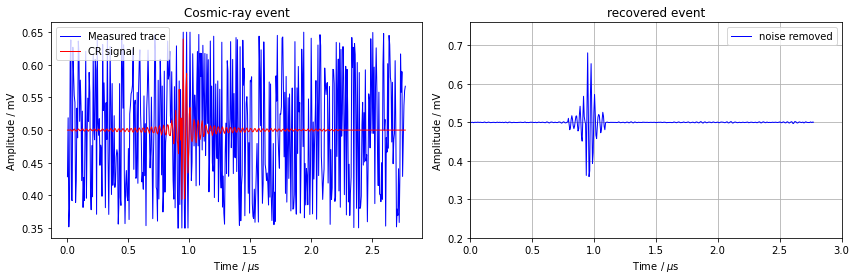

In [25]:
x, y, z = shownext()

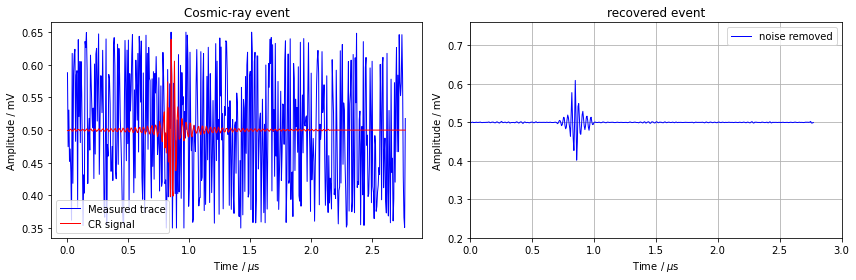

In [24]:


fs = 180e6  # Sampling frequency of antenna setup 180 MHz
t = np.arange(500) / fs * 1e6

def shownextxy(x,y):
    z = model(x.to(device))
    z = z.cpu()
    #return x, y,  z.detach().numpy()
    plt.figure(1, (12, 4))
    plt.subplot(1,2, 1)
    #plt.plot(t, np.real(f["traces"][labels.astype(bool)][idx]), linewidth = 1, color="b", label="Measured trace")
    plt.plot(t, np.real(x[0,0,:]), linewidth = 1, color="b", label="Measured trace")
    plt.plot(t, np.real(0.7*y[0,0,:]+0.15), linewidth = 1, color="r", label="CR signal")
    plt.ylabel('Amplitude / mV')
    plt.xlabel('Time / $\mu \mathrm{s}$')
    plt.legend()
    plt.title("Cosmic-ray event")
    plt.subplot(1, 2, 2)

    plt.plot(t, np.real(z[0,0,:].detach().numpy()), linewidth = 1, color="b", label="noise removed")
    plt.axis([0, 3.0, .2, .76])
    #plt.plot(t, np.real(x_train[~y_train.astype(bool)][idx2]), linewidth = 1, color="b", label="Measured trace")
    plt.ylabel('Amplitude / mV')
    plt.xlabel('Time / $\mu \mathrm{s}$')
    plt.legend()
    plt.title("recovered event")
    plt.grid(True)
    plt.tight_layout()
    return x, y,  z.detach().numpy()
x, y, z = shownextxy(x,y)


vmax = 171  zzimax= 171


Text(0.5, 0, 'Time / $\\mu \\mathrm{s}$')

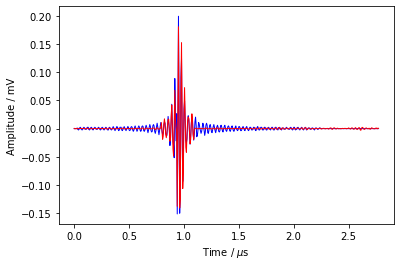

In [26]:
v = np.real(y[0,0, :]-0.5)
zz = np.real(z[0,0, :]-0.5)
zx = np.real(x[0,0,:]-0.5)
maxv = 0.0
vimax = 0
for i in range(500):
    if v[i] > maxv:
        maxv = v[i]
        vimax = i
maxzz = 0.0
zzimax = 0
for i in range(500):
    if zz[i] > maxzz:
        maxzz = zz[i]
        zzimax = i
print('vmax =', vimax, ' zzimax=', zzimax)
   
plt.plot(t, v, linewidth = 1, color="b", label="CR signal")
plt.plot(t, zz, linewidth = 1, color="r", label="CR signal")

plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')


In [27]:
def showspec(y, color ):
    samplingFrequency  = 500
    #v = np.real(y[0,0, :]-0.5)
    v = np.real(y-0.5)
    ft = np.fft.fft(v)/len(v)
    ft =ft[range(int(len(v)/2))]
    tpCount     = len(v)
    values      = np.arange(int(tpCount/2))
    timePeriod  = tpCount/samplingFrequency
    frequencies = values/timePeriod
    print(len(y), frequencies.shape, abs(ft).shape)
    plt.plot(frequencies, abs(ft), color)


500 (250,) (250,)
500 (250,) (250,)


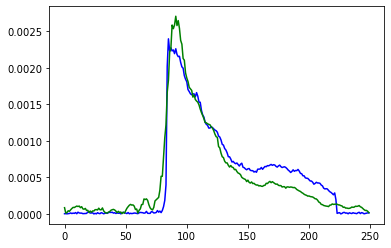

In [28]:
showspec(y[0,0,:], color="b") 
#showspec(puresin-sinw-(0.35-0.3419)+0.5, color = 'r')
showspec(z[0,0,:], color = 'g')

In [29]:
dataiter = iter(test_loader)
def makeScore(dataiter, number):
    count = 0
    good = 0
    for count in range(number):
        x,y = dataiter.next()
        #while y[0].std(axis=-1) == 0:
        #    x, y = dataiter.next()
        z = model(x.to(device))
        z = z.cpu().detach().numpy()
        v = np.real(y[0,0, :]-0.5).numpy()
        zz = np.real(z[0,0, :]-0.5)
        maxv = 0.0
        vimax = 0
        for i in range(500):
            if v[i] > maxv:
                maxv = v[i]
                vimax = i
        maxzz = 0.0
        zzimax = 0
        for i in range(500):
            if zz[i] > maxzz:
                maxzz = zz[i]
                zzimax = i
        #print('v=', maxv, vimax, ' zz=',maxzz, zzimax)
        if maxv == 0.0:
            if maxzz < .1:
                good+= 1
        elif abs(zzimax - vimax)< 10:
            good += 1
    print('accuracy = ', good/number)


In [30]:
dataiter = iter(test_loader)
makeScore(dataiter,2000)

accuracy =  0.9605


In [31]:
dataiter = iter(train_loader)
makeScore(dataiter,1000)

accuracy =  0.952


In [32]:
torch.save(model, "C:\\Users/\denni/\OneDrive/\Docs15/\model-original")

In [33]:
model = torch.load("C:\\Users/\denni/\OneDrive/\Docs15/\modelrandom-noise")
model.eval()

ConvDenoiser(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv0): ConvTranspose1d(16, 32, kernel_size=(2,), stride=(2,))
  (t_conv1): ConvTranspose1d(32, 32, kernel_size=(3,), stride=(2,))
  (t_conv2): ConvTranspose1d(32, 64, kernel_size=(2,), stride=(2,))
  (t_conv3): ConvTranspose1d(64, 32, kernel_size=(2,), stride=(2,))
  (conv_out): Conv1d(32, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)

In [34]:
def snr(data):
    rms = 0.0
    maxs = 0.0
    print(len(data))
    n = 0
    for x in data:
        y, sig = x
        for i in range(500):
            if sig[0,i] > maxs:
                maxs = sig[0,i]
            rms += y[0,i]*y[0,i]
            n+=1.0
    rms = np.sqrt(rms/n)
    print('rms =', rms)
    print('maxs =', maxs)
    print('sig to noise ratio', maxs/rms)
    
snr(traindat)

40000
rms = tensor(0.5124)
maxs = tensor(0.7042)
sig to noise ratio tensor(1.3742)
